# L3: Debug DSPy Agent with MLflow Tracing

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [7]:
from helper import get_openai_api_key

openai_api_key = get_openai_api_key()

import os

os.environ["OPENAI_API_KEY"] = get_openai_api_key()

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.</p>

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>
</div>

In [8]:
import mlflow

In [9]:
from helper import get_mlflow_tracking_uri

mlflow_tracking_uri = get_mlflow_tracking_uri()
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [10]:
mlflow.set_experiment("dspy_lesson_3")

<Experiment: artifact_location='mlflow-artifacts:/152345610695523823', creation_time=1751724204889, experiment_id='152345610695523823', last_update_time=1751724204889, lifecycle_stage='active', name='dspy_lesson_3', tags={}>

In [11]:
mlflow.dspy.autolog()

In [12]:
import dspy

dspy.configure(lm=dspy.LM("openai/gpt-4o-mini"))

### Build an Airline Customer Service Agent with dspy.ReAct

In [13]:
from pydantic import BaseModel


class Date(BaseModel):
    # Somehow LLM is bad at specifying `datetime.datetime`
    year: int
    month: int
    day: int
    hour: int


class UserProfile(BaseModel):
    user_id: str
    name: str
    email: str


class Flight(BaseModel):
    flight_id: str
    date_time: Date
    origin: str
    destination: str
    duration: float
    price: float


class Itinerary(BaseModel):
    confirmation_number: str
    user_profile: UserProfile
    flight: Flight


class Ticket(BaseModel):
    user_request: str
    user_profile: UserProfile

In [14]:
user_database = {
    "Adam": UserProfile(user_id="1", name="Adam", email="adam@gmail.com"),
    "Bob": UserProfile(user_id="2", name="Bob", email="bob@gmail.com"),
    "Chelsie": UserProfile(user_id="3", name="Chelsie", email="chelsie@gmail.com"),
    "David": UserProfile(user_id="4", name="David", email="david@gmail.com"),
}

flight_database = {
    "DA123": Flight(
        flight_id="DA123",
        origin="SFO",
        destination="JFK",
        date_time=Date(year=2025, month=9, day=1, hour=1),
        duration=3,
        price=200,
    ),
    "DA125": Flight(
        flight_id="DA125",
        origin="SFO",
        destination="JFK",
        date_time=Date(year=2025, month=9, day=1, hour=7),
        duration=9,
        price=500,
    ),
    "DA456": Flight(
        flight_id="DA456",
        origin="SFO",
        destination="SNA",
        date_time=Date(year=2025, month=10, day=1, hour=1),
        duration=2,
        price=100,
    ),
    "DA460": Flight(
        flight_id="DA460",
        origin="SFO",
        destination="SNA",
        date_time=Date(year=2025, month=10, day=1, hour=9),
        duration=2,
        price=120,
    ),
}

itinery_database = {}
ticket_database = {}

In [15]:
import random
import string


def fetch_flight_info(date: Date, origin: str, destination: str):
    """Fetch flight information from origin to destination on the given date"""
    flights = []

    for flight_id, flight in flight_database.items():
        if (
            flight.date_time.year == date.year
            and flight.date_time.month == date.month
            and flight.date_time.day == date.day
            and flight.origin == origin
            and flight.destination == destination
        ):
            flights.append(flight)
    return flights


def fetch_itinerary(confirmation_number: str):
    """Fetch a booked itinerary information from database"""
    return itinery_database.get(confirmation_number)


def pick_flight(flights: list[Flight]):
    """Pick up the best flight that matches users' request."""
    sorted_flights = sorted(
        flights,
        key=lambda x: (
            x.get("duration") if isinstance(x, dict) else x.duration,
            x.get("price") if isinstance(x, dict) else x.price,
        ),
    )
    return sorted_flights[0]


def generate_id(length=8):
    chars = string.ascii_lowercase + string.digits
    return "".join(random.choices(chars, k=length))


def book_itinerary(flight: Flight, user_profile: UserProfile):
    """Book a flight on behalf of the user."""
    confirmation_number = generate_id()
    while confirmation_number in itinery_database:
        confirmation_number = generate_id()
    itinery_database[confirmation_number] = Itinerary(
        confirmation_number=confirmation_number,
        user_profile=user_profile,
        flight=flight,
    )
    return confirmation_number, itinery_database[confirmation_number]


def cancel_itinerary(confirmation_number: str, user_profile: UserProfile):
    """Cancel an itinerary on behalf of the user."""
    if confirmation_number in itinery_database:
        del itinery_database[confirmation_number]
        return
    raise ValueError(
        "Cannot find the itinerary, please check your confirmation number."
    )


def get_user_info(name: str):
    """Fetch the user profile from database with given name."""
    return user_database.get(name)


def file_ticket(user_request: str, user_profile: UserProfile):
    """File a customer support ticket if this is something the agent cannot handle."""
    ticket_id = generate_id(length=6)
    ticket_database[ticket_id] = Ticket(
        user_request=user_request,
        user_profile=user_profile,
    )
    return ticket_id

In [16]:
class DSPyAirlineCustomerService(dspy.Signature):
    """You are an airline customer service agent. You are given a list of tools to handle user request. You should decide the right tool to use in order to fullfil users' request."""

    user_request: str = dspy.InputField()
    process_result: str = dspy.OutputField(
        desc="Message that summarizes the process result, and the information users need, e.g., the confirmation_number if it's a flight booking request."
    )

In [17]:
react = dspy.ReAct(
    DSPyAirlineCustomerService,
    tools=[
        fetch_flight_info,
        fetch_itinerary,
        pick_flight,
        book_itinerary,
        cancel_itinerary,
        get_user_info,
        file_ticket,
    ],
)

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Larger MLflow Tracer View:</b> f the MLflow tracer window displayed in the notebook appears too small, you can click the <b>"View in MLflow UI"</b> link in the top-right corner to open it in a new, full-screen tab.</p>
</div>

In [18]:
result = react(
    user_request="please help me book a flight from SFO to JFK on 09/01/2025, my name is Adam"
)

Trace(request_id=240af6740b464e52a6f9fbc2de5460ef)

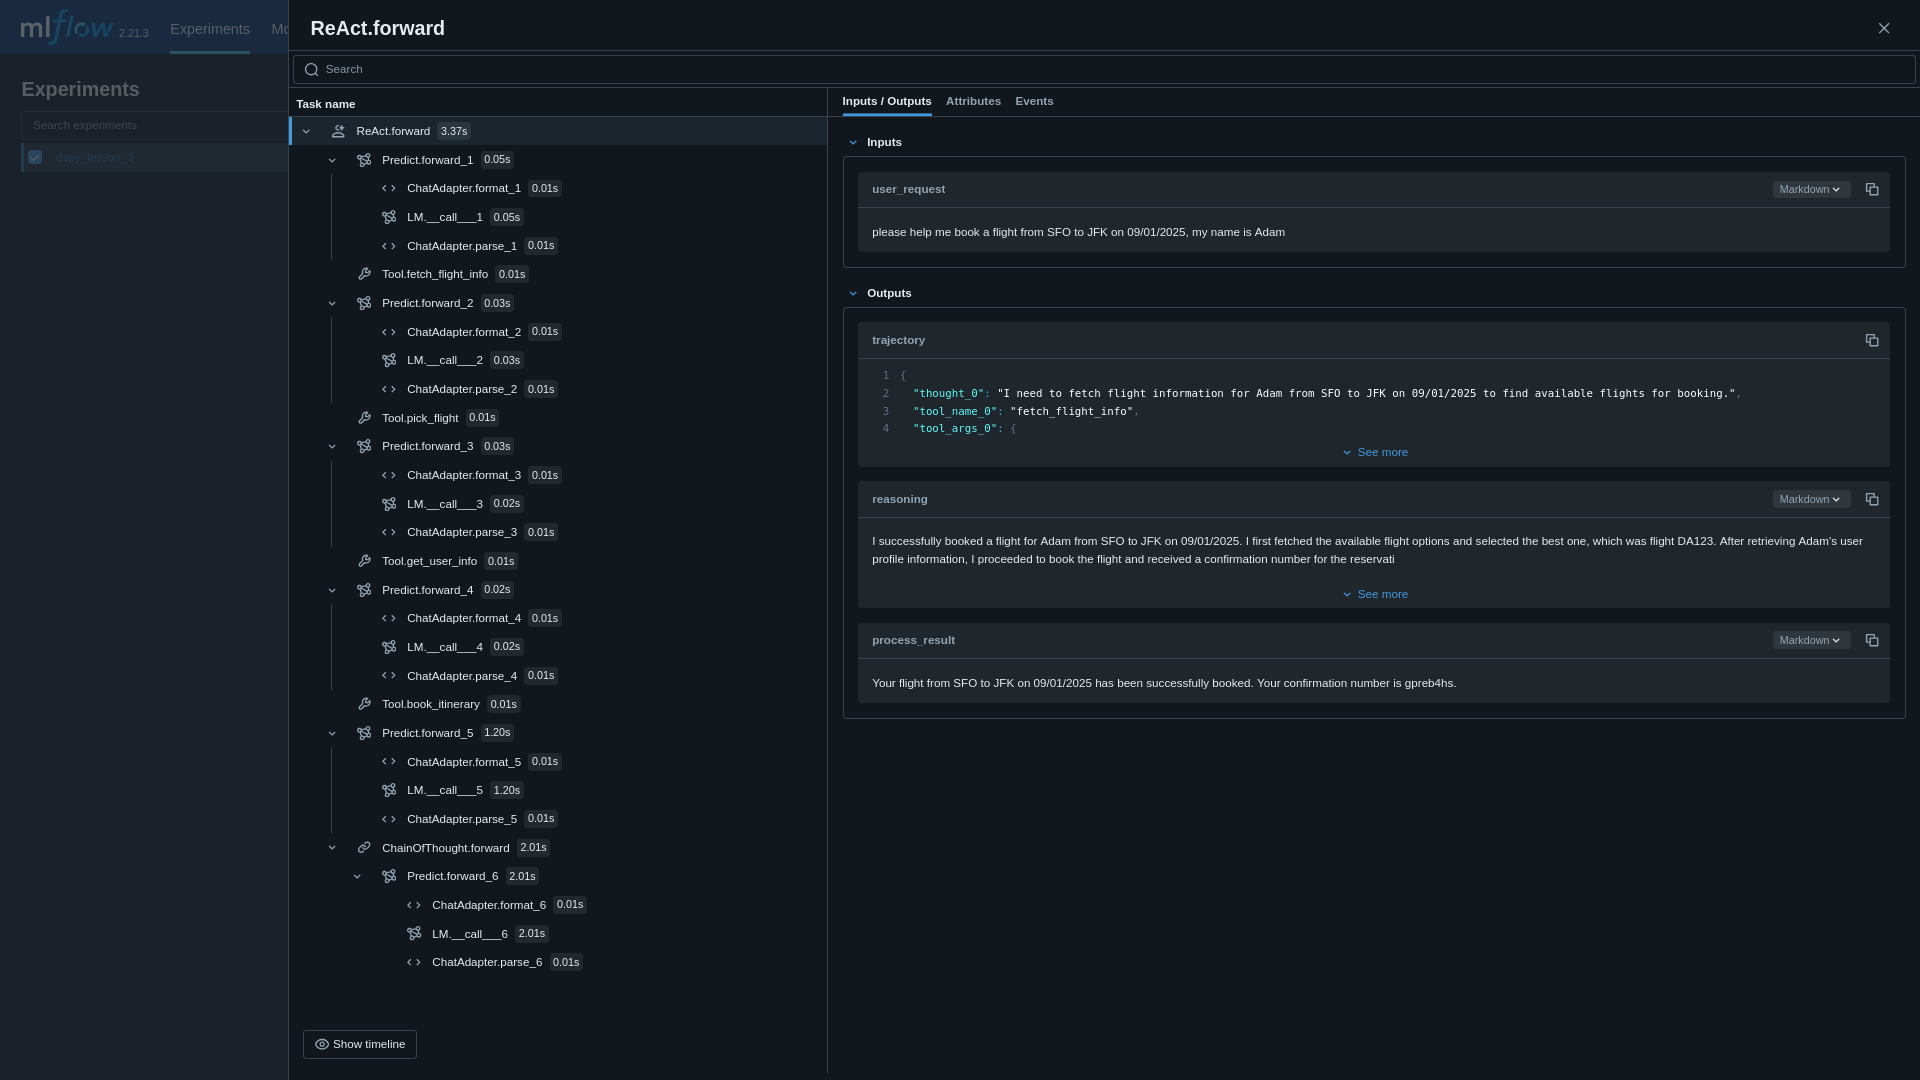

In [20]:
dspy.inspect_history(n=100)





[2025-07-05T14:06:20.199744]

System message:

Your input fields are:
1. `user_request` (str)
2. `trajectory` (str)
Your output fields are:
1. `next_thought` (str)
2. `next_tool_name` (Literal['fetch_flight_info', 'fetch_itinerary', 'pick_flight', 'book_itinerary', 'cancel_itinerary', 'get_user_info', 'file_ticket', 'finish'])
3. `next_tool_args` (dict[str, Any])
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## user_request ## ]]
{user_request}

[[ ## trajectory ## ]]
{trajectory}

[[ ## next_thought ## ]]
{next_thought}

[[ ## next_tool_name ## ]]
{next_tool_name}        # note: the value you produce must exactly match (no extra characters) one of: fetch_flight_info; fetch_itinerary; pick_flight; book_itinerary; cancel_itinerary; get_user_info; file_ticket; finish

[[ ## next_tool_args ## ]]
{next_tool_args}        # note: the value you produce must adhere to the JSON schema: {"type": "object", "additionalProperties": true}

[